# Figure 4: Conjoint Convergence

## Manuscript Information
 
"Active Mutual Conjoint Estimation of Multiple Contrast Sensitivity
Functions"
Dom CP Marticorena, Quinn Wai Wong, Jake Browning, Ken Wilbur, Pinakin Davey, Aaron R. Seitz, Jacob R. Gardner, Dennis L. Barbour
_Journal of Vision_

[link to paper or preprint]

## Lab and Institution Information

NeuroMedical Informatics Lab  
Washington University in St. Louis

## Figure Description

Mean ± standard deviation RMSE values in log contrast units for pairs of phenotypes averaged from 25
repeat experiments using up to 50 samples per phenotype (100 per pair). Data sources were first-generation disjoint
MLCRF (green), first-generation conjoint MLCRF (purple), second-generation disjoint MLCRF (blue), and second-
generation conjoint MLCRF (red). Data were actively sampled across both members of each pair, for (Normal,
Normal) (top), (Cataracts, Cataracts) (middle), and (Normal, Cataracts) pairs.

## References

[references]


### Imports

In [1]:
# Import libraries
import os
import sys
import torch
import gpytorch as gp

import math
import numpy as np

import datetime
import json
import pickle
import tqdm

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import seaborn as sns

# need access to root directory to import utils
parent_dir = os.path.dirname(os.path.abspath(''))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utility.utils import *

### Check versions

In [2]:
print("python version -->>", sys.version.split(" ")[0], "(expected 3.10.9)")
print("gpytorch version -->>", gp.__version__, "(expected 1.8.1)")
print("pytorch version -->>", torch.__version__, "(expected 1.13.1)")

python version -->> 3.10.9 (expected 3.10.9)
gpytorch version -->> 1.8.1 (expected 1.8.1)
pytorch version -->> 1.13.1 (expected 1.13.1)


### Run-time flags

In [3]:
train_mode = False          # create new data? Set to false if plotting existing results
verbose_mode = False        # print verbose analyses?
scrn_mode = True            # plot on screen?
save_results_mode = True    # save results to file?
save_plots_mode = True      # save plots to directory?

### Variables

In [4]:
# enums
NORMAL, CATARACTS, MILD_AMBLYOPIA, MULTIPLE_SCLEROSIS = ['Normal', 'Cataracts', 'Mild Amblyopia', 'Multiple Sclerosis']

# tasks and number of latents
num_latents = 2
sampling_method = 'alternating'     # 'alternating' or 'unconstrained'
weight_decay = 1e-4

# choose to run multiple experiments with preset random seeds
# or a single experiment specifying your own random seeds
run_multiple_experiments = True

# number of samples
num_halton_samples_per_task = 2
num_new_pts_per_task = 73

# choosing which figures to make
make_gp_gifs = True

# directory to save plots and results
# will save to the path <save_dir_prefix>/<current_timestamp>
save_dir_prefix = 'analysis/Figure04'

# Individual print flags
print_training_hyperparameters = False
print_training_iters = False
print_progress_bar = False

# Set all to true if verbose_mode
if verbose_mode:
    print_training_hyperparameters = False
    print_training_iters = True
    print_progress_bar = False

# Create the bounds for the data
raw_freq_min = 1
raw_freq_max = 64
raw_contrast_min = 1e-3
raw_contrast_max = 1

# Define how to transform the data
x_min = logFreq().forward(raw_freq_min)
x_max = logFreq().forward(raw_freq_max)
y_min = logContrast().forward(raw_contrast_max)  # max and min get flipped when inverting
y_max = logContrast().forward(raw_contrast_min)

# transform the data
def normalize_to_unit_range(d):
    return scale_data_within_range(d, (0, 1), x_min, x_max, y_min, y_max)

# marginal log resolutions of evaulation grid
x_resolution = 15  # 15 spatial frequencies per octave
y_resolution = 30  # 30 contrast units per decade

# for computing the proper prior threshold curve
psi_gamma  = 0.04  # guess rate is 4%
psi_lambda = 0.04 # lapse rate is 4%
psi_sigma = 0.08
sigmoid_type = 'logistic'

# training parameters?
num_initial_points_training_iters = 500
num_new_points_training_iters = 150
train_on_all_points_iters = 1500
sampling_strategy = 'active'
mean_module = 'constant_mean'
train_on_all_points_after_sampling = False
calculate_rmse = True
calculate_posterior = True
calculate_entropy = True

# GP hyperparameters?
learning_rate = .125
beta_for_regularization = .5
min_lengthscale = .15 # Note this changed from .2

# Set raw ghost points
raw_ghost_frequency = np.array([1, 2, 4, 8, 16, 32, 64, 128])
raw_ghost_contrast = np.array([5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 1])

# define the rows of the plot
subfolders = ['top', 'mid', 'bot'] # order matters
# select phenos to use for rows
subfolder_to_phenotypes = {
    'top': [NORMAL, NORMAL],
    'mid': [CATARACTS, CATARACTS],
    'bot': [NORMAL, CATARACTS]
}

qcsf_results_filename = '../manuscript1/data/qcsf_experiment_1/results_2023-09-22_15-38-10.json'

### Timestamp

In [5]:
# get current timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_dir = f"{save_dir_prefix}/{timestamp}/"
ensure_directory_exists(save_dir)
print(f"Saving to... {save_dir}")

Saving to... analysis/Figure04/2024-04-26_14-17-01/


### Automatically caluclated variables

In [6]:
# create common variables shared among all tasks
grid, xx, yy, xs, ys = create_evaluation_grid_resolution(
        x_min, x_max, y_min, y_max, x_resolution, y_resolution)

grid_transformed = transform_dataset(grid, phi=normalize_to_unit_range)

# function to get ground truth curves
def get_spline(curve):
    curve = np.array(curve)
    curve[:, 0] = (np.log2(10) * curve[:, 0]) - np.log2(.125)
    cs = create_cubic_spline(curve)
    return cs

num_tasks = 2


# get number of actively learned points for disjoint vs conjoint
num_pts_per_task = num_new_pts_per_task + num_halton_samples_per_task
num_new_conjoint_pts = num_new_pts_per_task * num_tasks
num_conjoint_pts = num_pts_per_task * num_tasks

# create ghost points and labels
ghost_x1 = logFreq().forward(raw_ghost_frequency)
ghost_x2 = logContrast().forward(raw_ghost_contrast)
assert len(ghost_x1) == len(ghost_x2), "x1 and x2 have diff lengths"

ghost_X = np.vstack((ghost_x1, ghost_x2)).T
ghost_y = np.array([0]*len(ghost_x2))

# create disjoint initial primer points
halton_X = get_halton_samples(xx, yy, num_halton_samples_per_task)
initial_disjoint_X = np.vstack((ghost_X, halton_X))

# create conjoint initial primer points and task indices
# simulated Halton y labels are created later for each experiment
halton_Xs = np.repeat(halton_X, num_tasks, axis=0)

num_ghost_points_per_task = len(ghost_y)
halton_task_indices = torch.arange(num_tasks).tile((num_halton_samples_per_task))

ghost_Xs = np.tile(ghost_X, (num_tasks, 1))
ghost_ys = np.tile(ghost_y, num_tasks)
ghost_task_indices = torch.arange(num_tasks).repeat_interleave(num_ghost_points_per_task)

num_disjoint_ghost_points = len(ghost_x2)
num_conjoint_ghost_points = len(ghost_task_indices)

# create initial dataset using ghost and halton samples
initial_Xs = np.vstack((ghost_Xs, halton_Xs))
initial_task_indices = torch.cat((ghost_task_indices, halton_task_indices))

# random seed lists for single vs multiple rounds
if run_multiple_experiments:
    num_exps = 25
    # unique random seeds for halton samples and training
    primer_seeds_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]
    gp_seed_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]
else:
    num_exps = 1
    primer_seeds_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]
    gp_seed_list = [(np.arange(num_tasks) + num_tasks*i).tolist() for i in range(num_exps)]

### Training

In [7]:

# get data selection
exp1_file = '../data/raw/csf_curves_exp1.json'
csf_curves_exp1 = load_json_from_file(exp1_file)
all_phenotypes = {MULTIPLE_SCLEROSIS: csf_curves_exp1['multiple_sclerosis'],
                  CATARACTS: csf_curves_exp1['cataracts'],
                  NORMAL: csf_curves_exp1['normal'],
                  MILD_AMBLYOPIA: csf_curves_exp1['mild_amblyopia']}

if train_mode:
    for subfolder, phenotypes in subfolder_to_phenotypes.items():

        specific_save_dir = save_dir + subfolder + '/'

        figure_dict = {
            "tasks": phenotypes,
            "num_latents": num_latents,
            "sampling_method": sampling_method,
            "num_exps": num_exps,
            "num_halton_samples_per_task": num_halton_samples_per_task,
            "num_new_pts_per_task": num_new_pts_per_task,
            "raw_freq_min": raw_freq_min,
            "raw_freq_max": raw_freq_max,
            "raw_contrast_min": raw_contrast_min,
            "raw_contrast_max": raw_contrast_max,
            "x_resolution": x_resolution,
            "y_resolution": y_resolution,
            "raw_ghost_frequency": raw_ghost_frequency.tolist(),
            "raw_ghost_contrast": raw_ghost_contrast.tolist(),
            "primer_seeds_list": primer_seeds_list,
            "gp_seed_list": gp_seed_list,
            "weight_decay": weight_decay,
            "min_lengthscale": min_lengthscale,
            "psi_sigma": psi_sigma,
            "sigmoid_type": sigmoid_type,
            "psi_gamma": psi_gamma,
            "psi_lambda": psi_lambda,
            "lr": learning_rate,
            "num_initial_training_iters": num_initial_points_training_iters,
            "num_new_points_training_iters": num_new_points_training_iters,
            "beta_for_regularization": beta_for_regularization,
            "train_on_all_points_after_sampling": train_on_all_points_after_sampling,
            "print_training_hyperparameters": print_training_hyperparameters,
            "print_training_iters": print_training_iters,
            "progress_bar": print_progress_bar,
            "calculate_rmse": calculate_rmse,
            "calculate_entropy": calculate_entropy,
            "calculate_posterior": calculate_posterior
        }

        ensure_directory_exists(specific_save_dir)
        with open(specific_save_dir + "run_configs.json", 'w') as file:
            json.dump(figure_dict, file, indent=2)





        phenotype_pair = [(pheno, all_phenotypes[pheno]) for pheno in phenotypes]
        ground_truths = [get_spline(pheno_data) for _, pheno_data in phenotypes]






        # disjoint

        disjoint_results_dicts = [{} for _ in range(num_tasks)]
        disjoint_gp_lists = []

        for exp in range(num_exps):
            print(f"Experiment {exp}")

            # get unique random seeds for each exp
            primer_seeds = primer_seeds_list[exp]
            gp_seeds = gp_seed_list[exp]


            for i, (pheno, _) in enumerate(phenotype_pair):
                print(pheno)

                cs = ground_truths[i]
                primer_seed = primer_seeds[i]
                gp_seed = gp_seeds[i]

                # get initial primer labels
                set_random_seed(primer_seed)
                halton_y = simulate_labeling(halton_X[:,0], halton_X[:,1], cs, 0, 0, sigmoid_type=sigmoid_type, psi_sigma=psi_sigma) # changed  psi_gamma, psi_lambda to 0, 0
                initial_y = np.hstack((ghost_y, halton_y))

                # run active learning
                set_random_seed(gp_seed)

                model, likelihood, X, y, rmse_list, _, posterior_list, _ = sample_and_train_gp(
                    cs,
                    grid,
                    xx,
                    yy,
                    sampling_strategy=sampling_strategy,
                    mean_module_name=mean_module,
                    psi_sigma=psi_sigma,
                    sigmoid_type=sigmoid_type,
                    psi_gamma=psi_gamma,
                    psi_lambda=psi_lambda,
                    lr=learning_rate,
                    num_initial_training_iters=num_initial_points_training_iters,
                    num_new_points_training_iters=num_new_points_training_iters,
                    num_new_points=num_new_pts_per_task,
                    beta_for_regularization=beta_for_regularization,
                    train_on_all_points_after_sampling=train_on_all_points_after_sampling,
                    train_on_all_points_iters=train_on_all_points_iters,
                    phi=normalize_to_unit_range,
                    print_training_hyperparameters=print_training_hyperparameters,
                    print_training_iters=print_training_iters,
                    progress_bar=print_progress_bar,
                    min_lengthscale=min_lengthscale,
                    calculate_rmse=calculate_rmse,
                    calculate_entropy=calculate_entropy,
                    calculate_posterior=calculate_posterior,
                    initial_Xs=initial_disjoint_X,
                    initial_ys=initial_y,
                    num_ghost_points=num_disjoint_ghost_points,
                    weight_decay=weight_decay,
                    kernel_config='new',
                    acq_config='new'
                )


                zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
                        .reshape(xx.shape)

                disjoint_results_dicts[i][exp] = {
                    'training_seed': gp_seed,
                    'random_seed': primer_seed,
                    'X': X,
                    'y': y,
                    'zz': zz,
                    'rmse_list': rmse_list
                }

                gif_dict = {
                    'xx': xx,
                    'yy': yy,
                    'X': X,
                    'y': y,
                    'cs': cs,
                    'psi_sigma': psi_sigma,
                    'sigmoid_type': sigmoid_type,
                    'psi_gamma': psi_gamma,
                    'psi_lambda': psi_lambda,
                    'x_min': x_min,
                    'x_max': x_max,
                    'y_min': y_min,
                    'y_max': y_max,
                    'xs': xs,
                    'ys': ys,
                    'grid': grid,
                    'f': normalize_to_unit_range,
                    'posterior_list': posterior_list,
                }

                # create gif of the task
                if make_gp_gifs and save_plots_mode:
                    ntitle = pheno.replace(' ', '_')
                    gif_path = f'{specific_save_dir}task{i}_{ntitle.lower()}/{exp}/'
                    ensure_directory_exists(gif_path)
                    create_and_save_plots(gif_dict, gif_path, ntitle, start_index=num_disjoint_ghost_points,
                                xticks_labels=x_tick_labels, yticks_labels=y_tick_labels)
                    create_gif(gif_path)

                gp_list = [model for model, _ in posterior_list]
                disjoint_gp_lists.append(gp_list)
                print()

            if save_results_mode:
                ensure_directory_exists(specific_save_dir)
                with open(f'{specific_save_dir}disjoint_results.pkl', 'wb') as file:
                    pickle.dump(disjoint_results_dicts, file)









        # disjoint old
        disjoint_results_dicts_old = [{} for _ in range(num_tasks)]
        disjoint_gp_lists_old = []

        for exp in range(num_exps):
            print(f"Experiment {exp}")

            # get unique random seeds for each exp
            primer_seeds = primer_seeds_list[exp]
            gp_seeds = gp_seed_list[exp]

            for i, (pheno, _) in enumerate(phenotype_pair):
                print(pheno)

                cs = ground_truths[i]
                primer_seed = primer_seeds[i]
                gp_seed = gp_seeds[i]

                # get initial primer labels
                set_random_seed(primer_seed)
                halton_y = simulate_labeling(halton_X[:,0], halton_X[:,1], cs, 0, 0, sigmoid_type=sigmoid_type, psi_sigma=psi_sigma) # changed  psi_gamma, psi_lambda to 0, 0
                initial_y = np.hstack((ghost_y, halton_y))

                # run active learning
                set_random_seed(gp_seed)

                model, likelihood, X, y, rmse_list, _, posterior_list, _ = sample_and_train_gp(
                    cs,
                    grid,
                    xx,
                    yy,
                    sampling_strategy=sampling_strategy,
                    mean_module_name=mean_module,
                    psi_sigma=psi_sigma,
                    sigmoid_type=sigmoid_type,
                    psi_gamma=psi_gamma,
                    psi_lambda=psi_lambda,
                    lr=learning_rate,
                    num_initial_training_iters=num_initial_points_training_iters,
                    num_new_points_training_iters=num_new_points_training_iters,
                    num_new_points=num_new_pts_per_task,
                    beta_for_regularization=beta_for_regularization,
                    train_on_all_points_after_sampling=train_on_all_points_after_sampling,
                    train_on_all_points_iters=train_on_all_points_iters,
                    phi=normalize_to_unit_range,
                    print_training_hyperparameters=print_training_hyperparameters,
                    print_training_iters=print_training_iters,
                    progress_bar=print_progress_bar,
                    min_lengthscale=min_lengthscale,
                    calculate_rmse=calculate_rmse,
                    calculate_entropy=calculate_entropy,
                    calculate_posterior=calculate_posterior,
                    initial_Xs=initial_disjoint_X,
                    initial_ys=initial_y,
                    num_ghost_points=num_disjoint_ghost_points,
                    weight_decay=weight_decay,
                    kernel_config='old',
                    acq_config='old'
                )


                zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
                        .reshape(xx.shape)

                disjoint_results_dicts_old[i][exp] = {
                    'training_seed': gp_seed,
                    'random_seed': primer_seed,
                    'X': X,
                    'y': y,
                    'zz': zz,
                    'rmse_list': rmse_list
                }

                gif_dict_old = {
                    'xx': xx,
                    'yy': yy,
                    'X': X,
                    'y': y,
                    'cs': cs,
                    'psi_sigma': psi_sigma,
                    'sigmoid_type': sigmoid_type,
                    'psi_gamma': psi_gamma,
                    'psi_lambda': psi_lambda,
                    'x_min': x_min,
                    'x_max': x_max,
                    'y_min': y_min,
                    'y_max': y_max,
                    'xs': xs,
                    'ys': ys,
                    'grid': grid,
                    'f': normalize_to_unit_range,
                    'posterior_list': posterior_list,
                }

                # create gif of the task
                if make_gp_gifs and save_plots_mode:
                    ntitle = pheno.replace(' ', '_')
                    gif_path = f'{specific_save_dir}task{i}_{ntitle.lower()}/{exp}/'
                    ensure_directory_exists(gif_path)
                    create_and_save_plots(gif_dict_old, gif_path, ntitle, start_index=num_disjoint_ghost_points,
                                xticks_labels=x_tick_labels, yticks_labels=y_tick_labels)
                    create_gif(gif_path)

                gp_list = [model for model, _ in posterior_list]
                disjoint_gp_lists_old.append(gp_list)
                print()

            if save_results_mode:
                ensure_directory_exists(specific_save_dir)
                with open(f'{specific_save_dir}disjoint_results_old.pkl', 'wb') as file:
                    pickle.dump(disjoint_results_dicts_old, file)











        # conjoint
        conjoint_results_dicts = {}
        conjoint_gp_lists = []

        for exp in range(num_exps):
            print(f"Experiment {exp}")

            # get unique random seeds for each exp
            primer_seeds = primer_seeds_list[exp]
            gp_seed = gp_seed_list[exp][0]

            # get unique halton labels for each experiment
            halton_y_list = []

            for i, _ in enumerate(phenotype_pair):
                cs = ground_truths[i]
                set_random_seed(primer_seeds[i])
                halton_y = simulate_labeling(halton_X[:,0], halton_X[:,1], cs, 0, 0, sigmoid_type=sigmoid_type, psi_sigma=psi_sigma)  # changed  psi_gamma, psi_lambda to 0, 0
                halton_y_list.append(halton_y)

            # stack all task halton labels then stack ghost with halton labels
            halton_ys = np.array([y for y_per_halton in zip(*halton_y_list) for y in y_per_halton])
            initial_ys = np.hstack((ghost_ys, halton_ys))

            # run active learning
            set_random_seed(gp_seed)

            model, likelihood, X, y, task_indices, rmse_list, entropy_list, posterior_list, _ = sample_and_train_gp_conjoint(
                cs=ground_truths,
                grid=grid,
                xx=xx,
                yy=yy,
                psi_sigma=psi_sigma,
                psi_gamma=psi_gamma,
                psi_lambda=psi_lambda,
                lr=learning_rate,
                num_initial_training_iters=num_initial_points_training_iters,
                num_new_points_training_iters=num_new_points_training_iters,
                num_new_points=num_new_conjoint_pts,
                beta_for_regularization=beta_for_regularization,
                phi=normalize_to_unit_range,
                print_training_hyperparameters=print_training_hyperparameters,
                print_training_iters=print_training_iters,
                train_on_all_points_after_sampling=train_on_all_points_after_sampling,
                train_on_all_points_iters=train_on_all_points_iters,
                min_lengthscale=min_lengthscale,
                initial_Xs=initial_Xs,
                initial_ys=initial_ys,
                sampling_strategy=sampling_strategy,
                num_ghost_points=num_conjoint_ghost_points,
                calculate_rmse=calculate_rmse,
                calculate_entropy=calculate_entropy,
                calculate_posterior=calculate_posterior,
                progress_bar=print_progress_bar,
                num_tasks=num_tasks,
                num_latents=num_latents,
                task_indices=initial_task_indices,
                sampling_method=sampling_method,
                weight_decay=weight_decay,
                kernel_config='new',
                acq_config='new'
            )

            zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
                .reshape((*xx.shape, num_tasks))

            conjoint_results_dicts[exp] = {
                'training_seed': gp_seed,
                'random_seeds': primer_seeds,
                'X': X,
                'y': y,
                'zz': zz,
                'task_indices': task_indices,
                'entropy_list': entropy_list,
                'rmse_list': rmse_list
            }

            gp_list = [model for model, _ in posterior_list]
            conjoint_gp_lists.append(gp_list)
            print()

            if save_results_mode:
                ensure_directory_exists(specific_save_dir)
                with open(f'{specific_save_dir}conjoint_results.pkl', 'wb') as file:
                    pickle.dump(conjoint_results_dicts, file)











        # conjoint old
        conjoint_results_dicts_old = {}
        conjoint_gp_lists_old = []
        
        for exp in range(num_exps):
            print(f"Experiment {exp}")
        
            # get unique random seeds for each exp
            primer_seeds = primer_seeds_list[exp]
            gp_seed = gp_seed_list[exp][0]
        
            # get unique halton labels for each experiment
            halton_y_list = []
        
            for i, _ in enumerate(phenotype_pair):
                cs = ground_truths[i]
                set_random_seed(primer_seeds[i])
                halton_y = simulate_labeling(halton_X[:,0], halton_X[:,1], cs, 0, 0, sigmoid_type=sigmoid_type, psi_sigma=psi_sigma)  # changed  psi_gamma, psi_lambda to 0, 0
                halton_y_list.append(halton_y)
        
            # stack all task halton labels then stack ghost with halton labels
            halton_ys = np.array([y for y_per_halton in zip(*halton_y_list) for y in y_per_halton])
            initial_ys = np.hstack((ghost_ys, halton_ys))
        
            # run active learning
            set_random_seed(gp_seed)
        
            model, likelihood, X, y, task_indices, rmse_list, entropy_list, posterior_list, _ = sample_and_train_gp_conjoint(
                cs=ground_truths,
                grid=grid,
                xx=xx,
                yy=yy,
                psi_sigma=psi_sigma,
                psi_gamma=psi_gamma,
                psi_lambda=psi_lambda,
                lr=learning_rate,
                num_initial_training_iters=num_initial_points_training_iters,
                num_new_points_training_iters=num_new_points_training_iters,
                num_new_points=num_new_conjoint_pts,
                beta_for_regularization=beta_for_regularization,
                phi=normalize_to_unit_range,
                print_training_hyperparameters=print_training_hyperparameters,
                print_training_iters=print_training_iters,
                train_on_all_points_after_sampling=train_on_all_points_after_sampling,
                train_on_all_points_iters=train_on_all_points_iters,
                min_lengthscale=min_lengthscale,
                initial_Xs=initial_Xs,
                initial_ys=initial_ys,
                sampling_strategy=sampling_strategy,
                num_ghost_points=num_conjoint_ghost_points,
                calculate_rmse=calculate_rmse,
                calculate_entropy=calculate_entropy,
                calculate_posterior=calculate_posterior,
                progress_bar=print_progress_bar,
                num_tasks=num_tasks,
                num_latents=num_latents,
                task_indices=initial_task_indices,
                sampling_method=sampling_method,
                weight_decay=weight_decay,
                kernel_config='old',
                acq_config='old'
            )
        
            zz = evaluate_posterior_mean(model, likelihood, grid_transformed) \
                .reshape((*xx.shape, num_tasks))
        
            conjoint_results_dicts_old[exp] = {
                'training_seed': gp_seed,
                'random_seeds': primer_seeds,
                'X': X,
                'y': y,
                'zz': zz,
                'task_indices': task_indices,
                'entropy_list': entropy_list,
                'rmse_list': rmse_list
            }
        
            gp_list = [model for model, _ in posterior_list]
            conjoint_gp_lists_old.append(gp_list)
            print()
        
            if save_results_mode:
                ensure_directory_exists(specific_save_dir)
                with open(f'{specific_save_dir}conjoint_results_old.pkl', 'wb') as file:
                    pickle.dump(conjoint_results_dicts_old, file)


## Load data

In [8]:
load_dir = 'D:/Repos/delete_me/Figure04/'
DISJOINT, CONJOINT, DISJOINT_OLD, CONJOINT_OLD = "new model: disjoint", "new model: conjoint", "original model: disjoint", "original model: conjoint"

all_loaded_results = dict()

for subfolder in subfolders:
    _loaded_results = dict()

    with open(load_dir + subfolder + '/disjoint_results.pkl', 'rb') as file:
        _loaded_results[DISJOINT] = pickle.load(file)

    with open(load_dir + subfolder + '/conjoint_results.pkl', 'rb') as file:
        _loaded_results[CONJOINT] = pickle.load(file)

    with open(load_dir + subfolder + '/disjoint_results_old.pkl', 'rb') as file:
        _loaded_results[DISJOINT_OLD] = pickle.load(file)

    with open(load_dir + subfolder + '/conjoint_results_old.pkl', 'rb') as file:
        _loaded_results[CONJOINT_OLD] = pickle.load(file)

    all_loaded_results[subfolder] = _loaded_results
    
    
    
    
# load qcsf results

with open(qcsf_results_filename, 'r') as file:
    qcsf_results_object = json.load(file)

## Create RMSE plots

### Formatting variables

In [17]:
subplots_adjust_params = {
    'bottom':0.1,
    'top':0.9,
    'left':0.1,
    'right':0.8,
    'wspace':0.08,
    'hspace':0.3
}

figure_width = 6.5  # inches
figure_height = 3*(figure_width / 2 / 2)  # inches

dpi_val = 600              # graphics resolution
plt.rcParams['font.family'] = 'sans-serif'


'''
(legend font size, the number in arange in rmse_y_ticks)
(4, 3.6)
(5, 4.6)
(6, 6.6)
(6, 8.6)

'''

legend_font_size = 6
legend_loc = 'upper right'
tick_font_size = 6
label_font_size = 8
title_font_size = 10

x_tick_labels = [1, 4, 16, 64]
y_tick_labels = [1, 0.1, 0.01, 0.001]

conditions = [
    (DISJOINT_OLD, 'red'),
    (CONJOINT_OLD, 'blue'),
    (DISJOINT, 'orange'),
    (CONJOINT, 'green'),
]

qcsf_color = 'purple'
qcsf_label = 'qCSF'

legend_mapping = {
    DISJOINT: '2nd gen disjoint',
    DISJOINT_OLD: '1st gen disjoint',
    CONJOINT: '2nd gen conjoint',
    CONJOINT_OLD: '1st gen conjoint'
}

rmse_x_label = "Sample Count"
rmse_y_label = "RMSE"

mean_linewidth = 1
std_linewidth = 1

std_transparency = 0.2

rmse_x_ticks = [0, 20, 40, 60, 80, 100]
rmse_y_ticks = np.arange(.86, step=0.1) # if you want 0.8, change to 0.86
rmse_x_ticks_min = rmse_x_ticks[0]
rmse_x_ticks_max = rmse_x_ticks[-1]
rmse_y_ticks_min = rmse_y_ticks[0]
rmse_y_ticks_max = rmse_y_ticks[-1] #+ 0.05

axis_tick_params = {
    'axis': 'both',
    'which': 'major',
    'direction': 'out',
    'length': 2
}

filename = 'Figure04_ConjointConvergence'


### Plotting

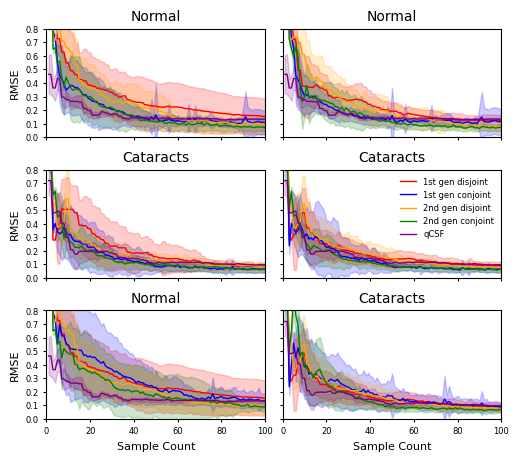

<Figure size 640x480 with 0 Axes>

In [16]:
%matplotlib inline

subplot_titles = {}
for subfolder in subfolders:
    with open(load_dir + subfolder + '/run_configs.json', 'r') as file:
        subplot_titles[subfolder] = json.load(file)['tasks']

# set up plot
num_cols = len(subplot_titles[subfolders[0]])
num_rows = len(subfolders)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(figure_width, figure_height))
sample_count = np.arange(1, num_conjoint_pts + 1)

# set up subplots
for row, subfolder in enumerate(subfolders):
    for col, title in enumerate(subplot_titles[subfolder]):
        ax = axs[row, col]

        for (condition, color) in conditions:
            results_dicts = all_loaded_results[subfolder][condition]
            all_rmses = np.zeros((num_exps, num_conjoint_pts))

            for exp_idx in range(num_exps):
                if condition in [DISJOINT, DISJOINT_OLD]:
                    disjoint_rmse_list = results_dicts[col][exp_idx]['rmse_list']
                    rmse_list = np.repeat(disjoint_rmse_list, num_tasks)
                elif condition in [CONJOINT, CONJOINT_OLD]:
                    rmse_list = results_dicts[exp_idx]['rmse_list'][col]
                else:
                    raise Exception("not a valid condition")

                all_rmses[exp_idx, :] = rmse_list

            mean = np.mean(all_rmses, axis=0)
            std = np.std(all_rmses, axis=0)

            label = legend_mapping[condition]
            ax.plot(sample_count, mean, label=label, color=color, linewidth=mean_linewidth)
            upper = mean + std
            lower = mean - std
            ax.fill_between(sample_count, upper, lower, alpha=std_transparency, color=color, linewidth=std_linewidth)
            
        # plot qcsf curve
        # TODO
        # I have an object named qcsf_results_object
        # qcsf_results_object[title] returns a list of dictionaries, each with a key "rmses" that corresponds to a list of numbers

        # plot qcsf curve
        qcsf_rmses_list = [d['rmses'] for d in qcsf_results_object[title]]
        qcsf_rmses = np.array(qcsf_rmses_list)
        qcsf_mean = np.mean(qcsf_rmses, axis=0)
        qcsf_mean = np.repeat(qcsf_mean[:50], 2) # create the staircase
        qcsf_std = np.std(qcsf_rmses, axis=0)
        ax.plot(sample_count[:len(qcsf_mean)], qcsf_mean, label=qcsf_label, color=qcsf_color, linewidth=mean_linewidth)
        qcsf_upper = qcsf_mean + qcsf_std
        qcsf_lower = qcsf_mean - qcsf_std
        ax.fill_between(sample_count[:len(qcsf_mean)], qcsf_upper, qcsf_lower, alpha=std_transparency, color=qcsf_color, linewidth=std_linewidth)
        
        
        ax.tick_params(**axis_tick_params, labelsize=tick_font_size)
        ax.set_xlim(rmse_x_ticks_min, rmse_x_ticks_max)
        ax.set_ylim(rmse_y_ticks_min, rmse_y_ticks_max)
        ax.set_title(title, fontsize=title_font_size)
        ax.set_xlabel(rmse_x_label, fontsize=label_font_size)
        ax.set_ylabel(rmse_y_label, fontsize=label_font_size)
        ax.label_outer()

# Place the legend on the rightmost subplot
axs[1, 1].legend(loc=legend_loc, fontsize=legend_font_size, frameon=False)
plt.setp(axs, xticks=rmse_x_ticks, yticks=rmse_y_ticks)
fig.subplots_adjust(**subplots_adjust_params)

if save_plots_mode:
    plt.savefig(f"{save_dir}{filename}.png", bbox_inches='tight', dpi=dpi_val)
    plt.savefig(f"{save_dir}{filename}.pdf", bbox_inches='tight', dpi=dpi_val)
if scrn_mode:
    plt.show()
plt.clf()